In [74]:
from bs4 import BeautifulSoup
import re

from urllib.request import urlopen
html = urlopen("https://en.wikipedia.org/wiki/Timeline_of_the_2020_coronavirus_pandemic_in_Iraq#cite_note-1").read()
# print(html)
cases = []
dates = []
Deaths = []
soup = BeautifulSoup(html)
chart = soup.find('div', attrs={'class': 'barbox tright'})
for elt in soup.find_all('tr'):
    if(len(elt)>=4):
        date,_,case,death = elt.find_all('td')
        cases.append(case.text.split('(')[0] if case.text else 0)
        dates.append(date.text)
        Deaths.append(death.text.split('(')[0] if death.text else 0)
    

print(len(cases))

53


In [75]:
import pandas as pd
from datetime import date
import datetime



# cleaning up data
for i in range(len(dates)):
    if('⋮' in dates[i]):
        start = datetime.datetime.strptime(dates[i-1], "%Y-%m-%d")
        start +=datetime.timedelta(days=1)
        end = datetime.datetime.strptime(dates[i+1], "%Y-%m-%d")
        date_array = \
        [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
        
        dates.pop(i)
        d=Deaths.pop(i)
        c=cases.pop(i)
        
        new_counter = i
        for date_object in date_array:
            # print(date_object.strftime("%Y-%m-%d"))
            dates.insert(new_counter, date_object.strftime("%Y-%m-%d"))
            Deaths.insert(new_counter, d)
            cases.insert(new_counter, c)
            new_counter+=1
            
for i in range(len(dates)):
    if('⋮' in dates[i]):
        dates.pop(i)
        Deaths.pop(i)
        cases.pop(i)            
            
for i in range(1, len(cases)):
    if type(cases[i]) is str:
        cases[i]=int(cases[i].replace(',',''))
    elif type(cases[i]) is float:
        cases[i]=int(cases[i])
    if type(Deaths[i]) is str:
        Deaths[i]=int(Deaths[i].replace(',',''))
    elif type(Deaths[i]) is float:
        Deaths[i]=int(Deaths[i])
            
            
    
print(len(dates),len(Deaths),len(cases))
df = pd.DataFrame({'Cases': cases[1:], 'Dates': dates[1:], 'Deaths': Deaths[1:]})
# df = df.drop(df[df.Dates == '⋮'].index)
df.set_index('Dates', inplace=True)
df.head()

# print(cases, dates, precentages)

60 60 60


,Cases,Deaths
Dates,,
2020-02-24,1,0
2020-02-25,1,0
2020-02-26,1,0
2020-02-27,1,0
2020-02-28,1,0


In [76]:
start = datetime.datetime.strptime("2020-02-24", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-04-19", "%Y-%m-%d")
date_array = \
len([start + datetime.timedelta(days=x) for x in range(0, (end-start).days)])
print(date_array)

55


In [77]:
df.to_csv("formatted-data.csv")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BEAE2C6B08>],
      dtype=object)

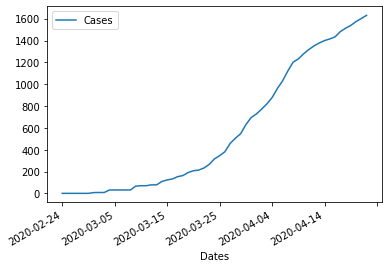

In [78]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd



# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False


# filtering my dataset to only use cases row

data = df.filter(['Cases'])
data.plot(subplots=True)

In [79]:
import math
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) 

In [80]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [81]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [82]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(5,len(train_data)):
    # for every 5 numbers going to x (input) 1 goes to y (expected output)
    x_train.append(train_data[i-5:i,0])
    y_train.append(train_data[i,0])
    

    
print(len(y_train))
print(len(x_train))

43
43


In [83]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print(y_train.shape)
print(x_train.shape)

(43,)
(43, 5)


In [84]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# (40, 5) to (40, 5, 1)
x_train.shape

(43, 5, 1)

In [85]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))




#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=4)

Epoch 1/4
43/43 [==============================] - 0s 5ms/step - loss: 2.9477e-04
Epoch 2/4
43/43 [==============================] - 0s 5ms/step - loss: 2.4897e-04
Epoch 3/4
43/43 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 8.3365e-04


In [96]:
#Test data set
#basicaly the same thing i did with the train data set
test_data = scaled_data[training_data_len - 5: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(5,len(test_data)):
    x_test.append(test_data[i-5:i,0])

In [109]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(11, 5, 1)

In [98]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [99]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

102.53805880915881

c:\users\omar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


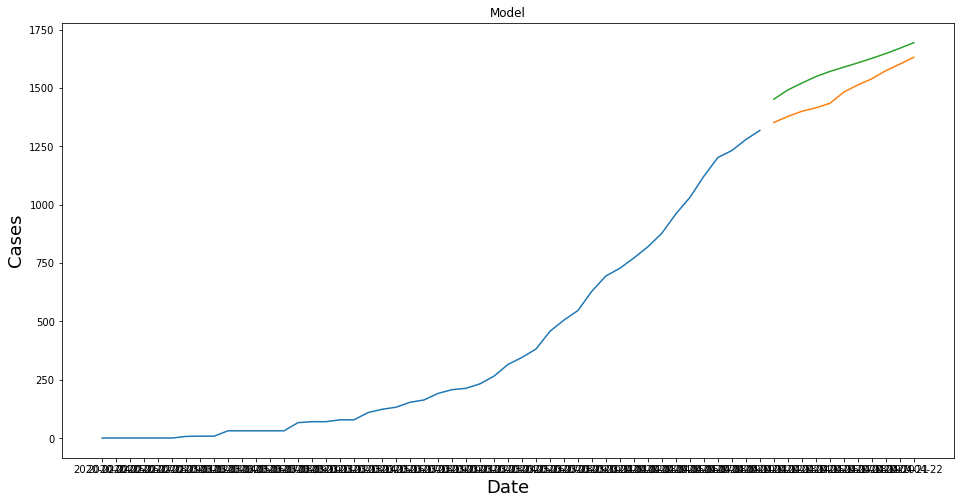

In [116]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.plot(train['Cases'])
plt.plot(valid[['Cases', 'Predictions']])
plt.show()

In [117]:
valid.head

<bound method NDFrame.head of             Cases  Predictions
Dates                         
2020-04-12   1352  1451.927490
2020-04-13   1378  1491.316162
2020-04-14   1400  1520.710327
2020-04-15   1415  1548.408325
2020-04-16   1434  1570.546997
2020-04-17   1482  1588.780640
2020-04-18   1513  1607.203247
2020-04-19   1539  1626.657715
2020-04-20   1574  1647.013916
2020-04-21   1602  1669.787109
2020-04-22   1631  1693.676392>

In [111]:
# actual predictions

#Convert x_test to a numpy array 
x_test2 = np.array(data[:5])

#Reshape the data into the shape accepted by the LSTM
x_test2 = np.reshape(x_test2, (1,x_test2.shape[0],1))
x_test2.shape

(1, 5, 1)

In [115]:
#Getting the models predicted price values
prediction = model.predict(x_test2) 
prediction = scaler.inverse_transform(prediction)#Undo scaling
int(prediction[0][0])

1757